In [5]:
import glob
import subprocess
import os
import json
import pandas as pd

# Processing Tweets

In [6]:
dir_ = "C:/Users/jhtchns2/Box/ACE 592 SAE - Spring 2023/Class_Examples/1_Text/"

First things first, clean up the text files.

### `sed` expressions
To clean these files, I am using two "sed" expressions that remove blank whitespace and make it a proper json file.
- `/^[[:space:]]*$/d` 
    - This one deletes lines that have only white space on them.
- `1s/^/[/;$!s/$/,/;$s/$/]/` 
    - This one puts a comma at the end of each line and brackets it with \[ and \]

In [7]:
for file in [dir_+"sorry_tweets.txt",dir_+"econ_tweets.txt"]:
    temp_file = open(dir_+"temp", "w")
    out_file = open(file.split("/")[-1].split(".")[0] + ".json", "a")
    sub = subprocess.call(['sed', '/^[[:space:]]*$/d',file], stdout=temp_file )
    sub = subprocess.call(['sed', '1s/^/[/;$!s/$/,/;$s/$/]/' , dir_+"temp"], stdout=out_file )

Now let's put them into one dictionary:

In [8]:
file_dict={}
for file in [dir_+"sorry_tweets.json",dir_+"econ_tweets.json"]:
    print(file)
    with open(file) as f:
        tweets = json.load(f)
    file_dict[file.split("/")[-1].split(".")[0]] = tweets

C:/Users/jhtchns2/Box/ACE 592 SAE - Spring 2023/Class_Examples/1_Text/sorry_tweets.json
C:/Users/jhtchns2/Box/ACE 592 SAE - Spring 2023/Class_Examples/1_Text/econ_tweets.json


In [9]:
file_dict.keys()

dict_keys(['sorry_tweets', 'econ_tweets'])

In [10]:
len(file_dict['sorry_tweets']),len(file_dict['econ_tweets'])

(1308, 2022)

Put them in dataframes:

In [11]:
df_S = pd.DataFrame()
df_S['timestamp'] = [x['created_at'] for x in file_dict['sorry_tweets']]

df_E = pd.DataFrame()
df_E['timestamp'] = [x['created_at'] for x in file_dict['econ_tweets']]

In [12]:
df_S['timestamp'][0],df_S['timestamp'].iloc[-1]

('Tue Feb 15 23:53:22 +0000 2022', 'Thu Feb 17 14:43:09 +0000 2022')

Oh look, who is this?

In [13]:
file_dict['sorry_tweets'][4]

{'created_at': 'Tue Feb 15 23:59:08 +0000 2022',
 'id': 1493736666653020163,
 'id_str': '1493736666653020163',
 'text': 'This is a test of my Twitter listening script.\n\nHi ACE 592 SAE!\n\n#econtwitter #sorrynotsorry',
 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 73939113,
  'id_str': '73939113',
  'name': 'Jared Hutchins',
  'screen_name': 'pablohutch',
  'location': 'Champaign, IL',
  'url': 'http://jaredphutchins.com',
  'description': 'Agricultural and applied economist, Assistant Professor at @aceatIL, alum of @UW_AAE; open source fanboy, occasional nature documentary enthusiast.',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 602,
  'friends_count': 487,
  'listed_count': 0,
  'favourites_coun

In [14]:
print(file_dict['sorry_tweets'][4]['text'])
print("\nfrom user: " + file_dict['sorry_tweets'][4]['user']['name'])
print("\ntweeted at this time: " + file_dict['sorry_tweets'][4]['created_at'])

This is a test of my Twitter listening script.

Hi ACE 592 SAE!

#econtwitter #sorrynotsorry

from user: Jared Hutchins

tweeted at this time: Tue Feb 15 23:59:08 +0000 2022


Full text is usually there.

In [15]:
file_dict['sorry_tweets'][1]['text']

'RT @Chantele_Rebel: Mood.... #SorryNotSorry https://t.co/t5rTxtEDC7'

But sometimes it isnt! Why?

In [16]:
file_dict['sorry_tweets'][2]['text']

'To pseuds and hackers alike. I am sorry that in the last 72 hours I have implicated every social media account by d… https://t.co/2hE6IFq7rs'

What keys does the second one have that the first one does not?

In [17]:
set(file_dict['sorry_tweets'][2].keys())-\
set(file_dict['sorry_tweets'][1].keys())

{'extended_tweet'}

In [18]:
file_dict['sorry_tweets'][2]['extended_tweet']['full_text']

'To pseuds and hackers alike. I am sorry that in the last 72 hours I have implicated every social media account by design. #sorryNotSorry #best #52'

So the full text is sometimes stored in a different key, sometimes not.

How can we find the text in each of these two places in the tweet?

Simple way: an `if` statement which checks if a certain key is present.

For example, we can first check if a status is a retweet or not:

In [19]:
for tweet in file_dict['sorry_tweets'][:5]:
    if "retweeted_status" in list(tweet.keys()):
        print("RT")
    else:
        print("not RT")

RT
RT
not RT
not RT
not RT


Now let's go a layer deeper to figure out if the tweet is extended or not:

In [20]:
for tweet in file_dict['sorry_tweets'][:30]:
    if "retweeted_status" in list(tweet.keys()):
        if "extended_tweet" in list(tweet['retweeted_status'].keys()):
            print("RT and extended")
        else:
            print("RT and not extended")
    else:
        print("not RT")

RT and not extended
RT and not extended
not RT
not RT
not RT
not RT
not RT
not RT
not RT
not RT
not RT
not RT
not RT
RT and not extended
not RT
not RT
not RT
not RT
not RT
not RT
not RT
not RT
RT and extended
not RT
not RT
not RT
not RT
RT and extended
not RT
RT and extended


We are missing a vital case though. What about if it's not a retweet but it is extended?

In [21]:
for tweet in file_dict['sorry_tweets'][:40]:
    if "retweeted_status" in list(tweet.keys()):
        if "extended_tweet" in list(tweet['retweeted_status'].keys()):
            print("RT and extended")
        else:
            print("RT and not extended")
    elif "extended_tweet" in list(tweet.keys()):
        print("not RT, extended")
    else:
        print("not RT, not extended")

RT and not extended
RT and not extended
not RT, extended
not RT, not extended
not RT, not extended
not RT, not extended
not RT, extended
not RT, extended
not RT, not extended
not RT, not extended
not RT, not extended
not RT, not extended
not RT, not extended
RT and not extended
not RT, not extended
not RT, not extended
not RT, extended
not RT, extended
not RT, extended
not RT, not extended
not RT, not extended
not RT, extended
RT and extended
not RT, not extended
not RT, extended
not RT, extended
not RT, extended
RT and extended
not RT, not extended
RT and extended
not RT, not extended
not RT, extended
not RT, not extended
not RT, not extended
RT and extended
RT and not extended
not RT, not extended
not RT, not extended
not RT, not extended
not RT, extended


Now let's amend this to capture the actual text by appending it to a list:

In [22]:
sorry_text = []
for tweet in file_dict['sorry_tweets']:
    if "retweeted_status" in list(tweet.keys()): # First evaluate whether RT
        if "extended_tweet" in list(tweet['retweeted_status'].keys()): # Next evaluate whether extended
            sorry_text.append(tweet['retweeted_status']['extended_tweet']['full_text'])
        else: # Else not extended
            sorry_text.append(tweet['retweeted_status']['text'])
    elif "extended_tweet" in list(tweet.keys()): # Next evaluate whether Not RT and extended
        sorry_text.append(tweet['extended_tweet']['full_text'])
    else: # Else not extended, not RT
        sorry_text.append(tweet['text'])

In [23]:
sorry_text[:6]

["New Tattoo! Can't wait to finish it my fucking back hurts #SorryNotSorry https://t.co/gqUzFxzwr3",
 'Mood.... #SorryNotSorry https://t.co/t5rTxtEDC7',
 'To pseuds and hackers alike. I am sorry that in the last 72 hours I have implicated every social media account by design. #sorryNotSorry #best #52',
 'This is some great information.  Check it out.',
 'This is a test of my Twitter listening script.\n\nHi ACE 592 SAE!\n\n#econtwitter #sorrynotsorry',
 'Me casoooooo ❤️😍🤤']

In [24]:
econ_text = []
for tweet in file_dict['econ_tweets']:
    if "retweeted_status" in list(tweet.keys()):
        if "extended_tweet" in list(tweet['retweeted_status'].keys()):
            econ_text.append(tweet['retweeted_status']['extended_tweet']['full_text'])
        else:
            econ_text.append(tweet['retweeted_status']['text'])
    elif "extended_tweet" in list(tweet.keys()):
        econ_text.append(tweet['extended_tweet']['full_text'])
    else:
        econ_text.append(tweet['text'])

In [25]:
econ_text[:5]

['"The extraordinarily large increases in two leading indicators of future rent inflation—asking rent inflation and house price inflation—point to significant upside risks to the overall inflation outlook."',
 'Call for papers for the 8th annual @SERI_Econ workshop https://t.co/fuYjrAZXB3 \nSubmission deadline: March 15 \nSubmission link: https://t.co/6aWNubkep2 #EconTwitter #EconConf #EconC4P #EconIndia https://t.co/Gy9ppCGHyI',
 'This is a test of my Twitter listening script.\n\nHi ACE 592 SAE!\n\n#econtwitter #sorrynotsorry',
 'Follow the money; always follow the money.\n\n#monetarysactions #econtwitter #poverty #policy https://t.co/rXE4R2oars',
 'PSID is searching for an economist to join its leadership team as a Research Professor or Research Associate Professor.\n\nJob posting: https://t.co/BvLqBaBtAF\n\n#NowHiring #econtwitter @umisr @UM_SRC\n \nApply by March 26th, 2022 https://t.co/Koskeg6bTQ']

In [26]:
df_S['text'] = sorry_text
df_E['text'] = econ_text

How do we know if its a RT?

Two ways:

In [27]:
df_S['RT_method1'] = ["retweeted_status" in list(x.keys()) for x in file_dict['sorry_tweets']] 

df_S['RT_method2'] = [x['text'][:2]=="RT" for x in file_dict['sorry_tweets']] 

In [28]:
df_S.head(10)

,timestamp,text,RT_method1,RT_method2
0,Tue Feb 15 23:53:22 +0000 2022,New Tattoo! Can't wait to finish it my fucking...,True,True
1,Tue Feb 15 23:55:09 +0000 2022,Mood.... #SorryNotSorry https://t.co/t5rTxtEDC7,True,True
2,Tue Feb 15 23:58:11 +0000 2022,To pseuds and hackers alike. I am sorry that i...,False,False
3,Tue Feb 15 23:58:56 +0000 2022,This is some great information. Check it out.,False,False
4,Tue Feb 15 23:59:08 +0000 2022,This is a test of my Twitter listening script....,False,False
5,Wed Feb 16 00:02:19 +0000 2022,Me casoooooo ❤️😍🤤,False,False
6,Wed Feb 16 00:02:23 +0000 2022,envie de poster des trucs visés sur les réseau...,False,False
7,Wed Feb 16 00:02:34 +0000 2022,So I think My twitter is more of a whore accou...,False,False
8,Wed Feb 16 00:04:08 +0000 2022,@FIFC Can confirm I was singing I hate Dover #...,False,False
9,Wed Feb 16 00:04:31 +0000 2022,So I just found out my Infiniti can take on my...,False,False


But didn't the 6th tweet quote something?

In [29]:
file_dict['sorry_tweets'][5]

{'created_at': 'Wed Feb 16 00:02:19 +0000 2022',
 'id': 1493737467274350598,
 'id_str': '1493737467274350598',
 'text': 'Me casoooooo ❤️😍🤤',
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1294416602381787137,
  'id_str': '1294416602381787137',
  'name': 'Mi Niña',
  'screen_name': 'ninanortenita',
  'location': 'CDMX',
  'url': None,
  'description': 'SCORT Sinaloense 🤠\nTrans super HOT all the time 🔥\ny muy MORBOSA, fan de ver BULTOS en la calle🍆 Hombres varoniles, barbones y altos 🤤\nPregunta DM para info',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 1304,
  'friends_count': 210,
  'listed_count': 0,
  'favourites_count': 2653,
  'statuses_count': 1497,
  'created_at': 'Fri Aug 14 23:3

We can figure out whether we have a quote this way:

In [31]:
df_S['quoted'] = ["quoted_status" in list(x.keys()) for x in file_dict['sorry_tweets']] 

df_S.head(10)

,timestamp,text,RT_method1,RT_method2,quoted
0,Tue Feb 15 23:53:22 +0000 2022,New Tattoo! Can't wait to finish it my fucking...,True,True,False
1,Tue Feb 15 23:55:09 +0000 2022,Mood.... #SorryNotSorry https://t.co/t5rTxtEDC7,True,True,False
2,Tue Feb 15 23:58:11 +0000 2022,To pseuds and hackers alike. I am sorry that i...,False,False,False
3,Tue Feb 15 23:58:56 +0000 2022,This is some great information. Check it out.,False,False,True
4,Tue Feb 15 23:59:08 +0000 2022,This is a test of my Twitter listening script....,False,False,False
5,Wed Feb 16 00:02:19 +0000 2022,Me casoooooo ❤️😍🤤,False,False,True
6,Wed Feb 16 00:02:23 +0000 2022,envie de poster des trucs visés sur les réseau...,False,False,False
7,Wed Feb 16 00:02:34 +0000 2022,So I think My twitter is more of a whore accou...,False,False,False
8,Wed Feb 16 00:04:08 +0000 2022,@FIFC Can confirm I was singing I hate Dover #...,False,False,False
9,Wed Feb 16 00:04:31 +0000 2022,So I just found out my Infiniti can take on my...,False,False,False


### Bonus Exercise: How could we extract the quoted text?
Hint: if else statements, but also remember that the resulting list should be the same length as the dataframe...

In [32]:
df_E['RT'] = ["retweeted_status" in list(x.keys()) for x in file_dict['econ_tweets']] 
df_E['quoted'] = ["quoted_status" in list(x.keys()) for x in file_dict['econ_tweets']] 

## Word Counts

In the econtwitter tweets:

In [33]:
import string
string.punctuation

# This maketrans function can be used to remove a list of characters from a string.
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”')

df_E['text_lower'] =  df_E['text'].str.lower().str.replace("\n"," ")

df_E['text_clean'] = df_E.text_lower.str.translate(remv_punc)

In [34]:
from nltk.corpus import stopwords

sw_list = stopwords.words('english') + ['amp',''," ","econtwitter"]

df_E['words'] = [x.split(" ") for x in df_E['text_clean']]

In [35]:
df_E['words'] = [list(set(x) - set(sw_list)) for x in df_E['words']]

In [36]:
series_list = [pd.Series(x).value_counts() for x in df_E['words']]
word_df_E = pd.concat(series_list,axis=1).fillna(0).T

C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_1188\835178494.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_list = [pd.Series(x).value_counts() for x in df_E['words']]


In [37]:
word_df_E.sum().sort_values(ascending=False).head(20)

new              350.0
us               346.0
work             241.0
economics        226.0
check            216.0
come             209.0
best             209.0
website          201.0
send             200.0
inflation        198.0
leading          197.0
journals         197.0
group            192.0
jpolecon         191.0
set              190.0
proud            189.0
announce         189.0
6                187.0
soon             186.0
distinguished    185.0
dtype: float64

In [38]:
import string
string.punctuation

# This maketrans function can be used to remove a list of characters from a string.
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”')

df_S['text_lower'] =  df_S['text'].str.lower().str.replace("\n","")

df_S['text_clean'] = df_S.text_lower.str.translate(remv_punc)

from nltk.corpus import stopwords

sw_list = stopwords.words('english') + ['amp',''," ","sorrynotsorry"]

df_S['words'] = [x.split(" ") for x in df_S['text_clean']]

df_S['words'] = [list(set(x) - set(sw_list)) for x in df_S['words']]

series_list = [pd.Series(x).value_counts() for x in df_S['words']]
word_df_S = pd.concat(series_list,axis=1).fillna(0).T

C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_1188\3965326334.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_list = [pd.Series(x).value_counts() for x in df_S['words']]
C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_1188\3965326334.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_list = [pd.Series(x).value_counts() for x in df_S['words']]
C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_1188\3965326334.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_list = [pd.Series(x).value_counts() for x in df_S['words']]
C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_1188\3965326334.py:19: FutureWarning: The default dty

In [39]:
word_df_S.sum().sort_values(ascending=False).head(25)

la            169.0
de            149.0
el            107.0
se            103.0
que            94.0
con            93.0
es             83.0
va             80.0
cuando         79.0
like           78.0
les            78.0
e              76.0
cada           74.0
poder          73.0
ahí            73.0
acabe          72.0
algunos        72.0
acción         71.0
vínculo        71.0
narcos         71.0
impunidad      71.0
olviden        71.0
ignoren        71.0
quedando       71.0
registrado     71.0
dtype: float64

#### What happened? (Que pasó?)

In [40]:
import string
string.punctuation

# This maketrans function can be used to remove a list of characters from a string.
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”')

df_S['text_lower'] =  df_S['text'].str.lower().str.replace("\n","")

df_S['text_clean'] = df_S.text_lower.str.translate(remv_punc)

from nltk.corpus import stopwords

sw_list = stopwords.words('english') + stopwords.words('spanish') + ['amp',''," ","sorrynotsorry"]

df_S['words'] = [x.split(" ") for x in df_S['text_clean']]

df_S['words'] = [list(set(x) - set(sw_list)) for x in df_S['words']]

series_list = [pd.Series(x).value_counts() for x in df_S['words']]
word_df_S = pd.concat(series_list,axis=1).fillna(0).T

C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_1188\1916797237.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_list = [pd.Series(x).value_counts() for x in df_S['words']]
C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_1188\1916797237.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_list = [pd.Series(x).value_counts() for x in df_S['words']]
C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_1188\1916797237.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_list = [pd.Series(x).value_counts() for x in df_S['words']]
C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_1188\1916797237.py:19: FutureWarning: The default dty

In [41]:
word_df_S.sum().sort_values(ascending=False).head(20)

va                 80.0
like               78.0
cada               74.0
ahí                73.0
poder              73.0
acabe              72.0
abuso              71.0
aúnque             71.0
ignoren            71.0
corrupción         71.0
acaba              71.0
acto               71.0
antidemocrática    71.0
registrado         71.0
quedando           71.0
acción             71.0
narcos             71.0
vínculo            71.0
impunidad          71.0
olviden            71.0
dtype: float64

### ????

### Then I found this tweet...

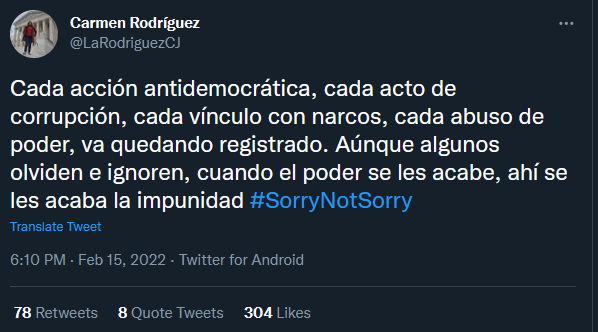

Notice how many times it's been retweeted...

In [42]:
S_word_sums = word_df_S.sum(axis=0)

S_word_sums[S_word_sums<71].sort_values(ascending=False).head(20)

people                49.0
get                   47.0
ser                   47.0
sorry                 44.0
i’m                   43.0
love                  41.0
gym                   38.0
raza                  37.0
aria                  37.0
indígena              37.0
nueva                 37.0
httpstcoi0itblyio5    35.0
dont                  35.0
selfies               35.0
say                   34.0
si                    33.0
im                    33.0
don’t                 32.0
think                 32.0
it’s                  30.0
dtype: float64

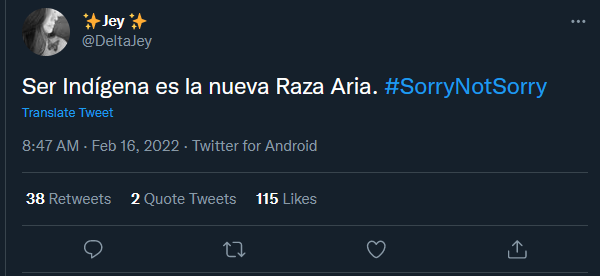

What is the problem here? How would we fix it?

In [43]:
df_S['text'].nunique(), len(df_S)

(957, 1308)

Alot of these tweets are just RTs...

Here's what happens if we don't count RTs.

In [44]:
unique_tweets = df_S['text_clean'].drop_duplicates()
unique_words = [x.split(" ") for x in unique_tweets]

unique_words = [list(set(x) - set(sw_list)) for x in unique_words]

series_list = [pd.Series(x).value_counts() for x in unique_words]
word_df_S_unique = pd.concat(series_list,axis=1).fillna(0).T

C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_1188\184949714.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series_list = [pd.Series(x).value_counts() for x in unique_words]


In [45]:
word_df_S_unique.sum().sort_values(ascending=False).head(20)

like      64.0
get       37.0
i’m       36.0
people    35.0
love      34.0
im        32.0
sorry     32.0
si        29.0
think     28.0
don’t     26.0
really    25.0
dont      24.0
good      24.0
it’s      23.0
go        22.0
much      21.0
one       21.0
say       21.0
see       19.0
still     19.0
dtype: float64

With EconTwitter :

In [46]:
unique_tweets = df_E['text_clean'].drop_duplicates()
unique_words = [x.split(" ") for x in unique_tweets]

unique_words = [list(set(x) - set(sw_list)) for x in unique_words]

series_list = [pd.Series(x).value_counts() for x in unique_words]
word_df_E_unique = pd.concat(series_list,axis=1).fillna(0).T
word_df_E_unique.sum().sort_values(ascending=False).head(25)

econtwitter           529.0
economics              70.0
new                    58.0
inflation              58.0
wsj                    57.0
nytimes                54.0
bloomberg              54.0
antitrust              53.0
economic               52.0
cnbc                   52.0
wapo                   50.0
paper                  49.0
cnn                    48.0
bigtech                47.0
economy                47.0
research               41.0
latimes                41.0
us                     37.0
economists             29.0
big                    27.0
httpstco3jzisqtt5h     27.0
join                   23.0
great                  23.0
2022                   22.0
work                   22.0
dtype: float64